The goal of this exercise is to determine the risk of a person in developing a Cardiovascular Disease (CVD), such as heart attacks, based on features of their personal lifestyle factors.  
Respondents (participants) were classified as having coronary heart disease (MICHD) if they reported having been tol by a provider they had MICH or if they reported having been told they had a heart attacks or angina.  

It is our job to use the data to build a model able to estimate the likelihood of developing MICHD given a certain clinical and lifestyle situation.  

x_train and x_test : each row corresponds to a person and each column to an health related data  
y_train : Id = correspond to data ID in x_train ; 1 = the person have a MICHD ; -1 = the person does not have a MICHD

In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv

%load_ext autoreload
%autoreload 2


In [3]:
from helpers import load_csv_data

# load data.
data_path = './dataset/'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)


## Data Preprocessing ##  

1. Select only the column that might have a correlation to the output (based on personal knowledge or assumption)

In [4]:
selected_columns = [
    "CVDINFR4", "CVDCRHD4", "CVDSTRK3", "BPHIGH4", "TOLDHI2", "DIABETE3",
    "SMOKE100", "SMOKDAY2", "ALCDAY5", "EXERANY2", "FRUIT1", "VEGETAB1",
    "SEX", "AGE", "INCOME2", "EDUCA", "BMI", "GENHLTH", "PHYSHLTH", 
    "MENTHLTH", "POORHLTH", "CHECKUP1", "BPMEDS", "BLOODCHO", "CHOLCHK", 
    "TOLDHI2", "ASTHMA3", "ASTHNOW", "CHCSCNCR", "CHCOCNCR", "CHCCOPD1",
    "ADDEPEV2", "CHCKIDNY", "EMPLOY1", "WEIGHT2", "HEIGHT3", "DIFFWALK",
    "AVEDRNK2", "FVGGREEN", "EXERHMM1", "PREDIAB1", "QLMENTL2", "QLSTRES2",
    "CVDASPRN", "SCNTMNY1"
]

# Ouvrir le fichier CSV
with open('./dataset/x_train.csv', newline='', encoding='utf-8') as csvfile:
    # Lire le fichier CSV avec le lecteur csv
    columns_name = csvfile.readline().strip().split(',')

# Indices des colonnes à conserver
indices_colonnes = [columns_name.index(col) for col in selected_columns if col in columns_name]
x_train = np.genfromtxt('./dataset/x_train.csv', delimiter=',', skip_header=1, usecols=indices_colonnes, dtype=float)
x_test = np.genfromtxt('./dataset/x_test.csv', delimiter=',', skip_header=1, usecols=indices_colonnes, dtype=float)

2. Standardize the remaining data :  

Normalize each feature in x_train and x_test so that they have a mean of 0 and standard deviation of 1. This is particularly useful for algorithms like logistic regression and gradient descent.

In [5]:
def standardization(data):
    """
    Standardize each column in the dataset  to have a mean of 0 and standard deviation of 1.

    Args:
        data: numpy array of shape (N, D) where N is the number of samples and D is the number of features.

    Returns:
        standardized_data: numpy array of shape (N, D) with standardized columns.
    """
    # Mean and Standard deviation for each column
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    

    standardized_data = (data - mean) / std
    
    return standardized_data

In [6]:
x_train_std = standardization(x_train)
x_test_std = standardization(x_test)

3. Handle Imbalanced Classes :  

f there is a strong imbalance between the MICHD and non-MICHD labels in y_train, consider balancing the classes.

In [7]:
def balance_classes(x_train, y_train):
    """
    Balances x_train and y_train to have an equal number of -1 and 1 labels.
    
    Args:
        x_train: numpy array of shape (N, D), where N is the number of samples and D is the number of features.
        y_train: numpy array of shape (N,), where N is the number of samples and each entry is either 1 or -1.
        
    Returns:
        x_train_balanced: numpy array of balanced samples.
        y_train_balanced: numpy array of balanced labels.
    """
    # Find indices for each class
    indices_class_1 = np.where(y_train == 1)[0]
    indices_class_neg_1 = np.where(y_train == -1)[0]
    
    # Determine the smaller class size
    min_class_size = min(len(indices_class_1), len(indices_class_neg_1))
    
    # Randomly select indices to balance the classes
    balanced_indices_class_1 = np.random.choice(indices_class_1, min_class_size, replace=False)
    balanced_indices_class_neg_1 = np.random.choice(indices_class_neg_1, min_class_size, replace=False)
    
    # Combine indices and shuffle
    balanced_indices = np.concatenate([balanced_indices_class_1, balanced_indices_class_neg_1])
    np.random.shuffle(balanced_indices)
    
    # Filter x_train and y_train based on balanced indices
    x_train_balanced = x_train[balanced_indices]
    y_train_balanced = y_train[balanced_indices]
    
    return x_train_balanced, y_train_balanced

In [8]:
x_train_bal, y_train_bal = balance_classes(x_train_std, y_train)

print(x_train_bal.shape)
print(x_train_std.shape)
print(y_train_bal.shape)
print(y_train.shape)

(57950, 38)
(328135, 38)
(57950,)
(328135,)


In [9]:
def replace_nan_with_zero(x_train):
    """
    Replace NaN values in x_train with 0.

    Args:
        x_train: numpy array of shape (N, D), where N is the number of samples and D is the number of features.

    Returns:
        x_train_clean: numpy array of shape (N, D) with NaN values replaced by 0.
    """
    # Replace NaN with 0
    x_train_clean = np.nan_to_num(x_train, nan=0.0)
    
    
    return x_train_clean
x_train_bal = replace_nan_with_zero(x_train_bal)

## Feature Importance Analysis ##

1. Correlation Analysis : high positive or negative correlation suggests that a feature may be impactful

In [10]:
import seaborn as sns 

def compute_correlations(x_train, y_train):
    """
    Computes the correlation coefficients between each feature in x_train and the target y_train.
    
    Args:
        x_train: numpy array of shape (N, D) where N is the number of samples and D is the number of features.
        y_train: numpy array of shape (N,) where N is the number of samples.
    
    Returns:
        correlations: numpy array of shape (D,) with correlation coefficients for each feature.
    """
    # Initialiser un tableau pour stocker les corrélations
    correlations = []
    
    # Calculer la corrélation pour chaque colonne de x_train avec y_train
    for i in range(x_train.shape[1]):
        feature_column = x_train[:, i]
        
        # Calculer la corrélation en excluant les NaN
        valid_mask = ~np.isnan(feature_column) & ~np.isnan(y_train)
        correlation = np.corrcoef(feature_column[valid_mask], y_train[valid_mask])[0, 1]
        
        # Ajouter la corrélation calculée à la liste
        correlations.append(correlation)
        
    return np.array(correlations)

def plot_correlation_heatmap(x_train, y_train, feature_names):
    """
    Plots a heatmap of the correlation coefficients between features in x_train and y_train.
    
    Args:
        x_train: numpy array of shape (N, D) where N is the number of samples and D is the number of features.
        y_train: numpy array of shape (N,) where N is the number of samples.
        feature_names: list of strings, names of the features in x_train.
    """
    # Calculer la matrice de corrélation complète, y compris la cible
    data_with_y = np.column_stack((x_train, y_train))
    corr_matrix = np.corrcoef(data_with_y, rowvar=False)
    print(corr_matrix)
    # Créer une heatmap de la matrice de corrélation avec la palette "Spectral"
    plt.figure(figsize=(15, 8))
    sns.heatmap(corr_matrix, cmap="Spectral", xticklabels=feature_names + ["MICHD"], yticklabels=feature_names + ["MICHD"], cbar=True,)
    plt.title("Matrice de corrélation des caractéristiques et de MICHD")
    plt.show()

[[ 1.          0.07649433  0.03650376 ...  0.0123806   0.01546637
  -0.11944212]
 [ 0.07649433  1.          0.21049748 ...  0.05374298  0.00664431
  -0.35278001]
 [ 0.03650376  0.21049748  1.         ...  0.02786206  0.01420967
  -0.17960308]
 ...
 [ 0.0123806   0.05374298  0.02786206 ...  1.         -0.00278661
  -0.07454754]
 [ 0.01546637  0.00664431  0.01420967 ... -0.00278661  1.
  -0.02370124]
 [-0.11944212 -0.35278001 -0.17960308 ... -0.07454754 -0.02370124
   1.        ]]


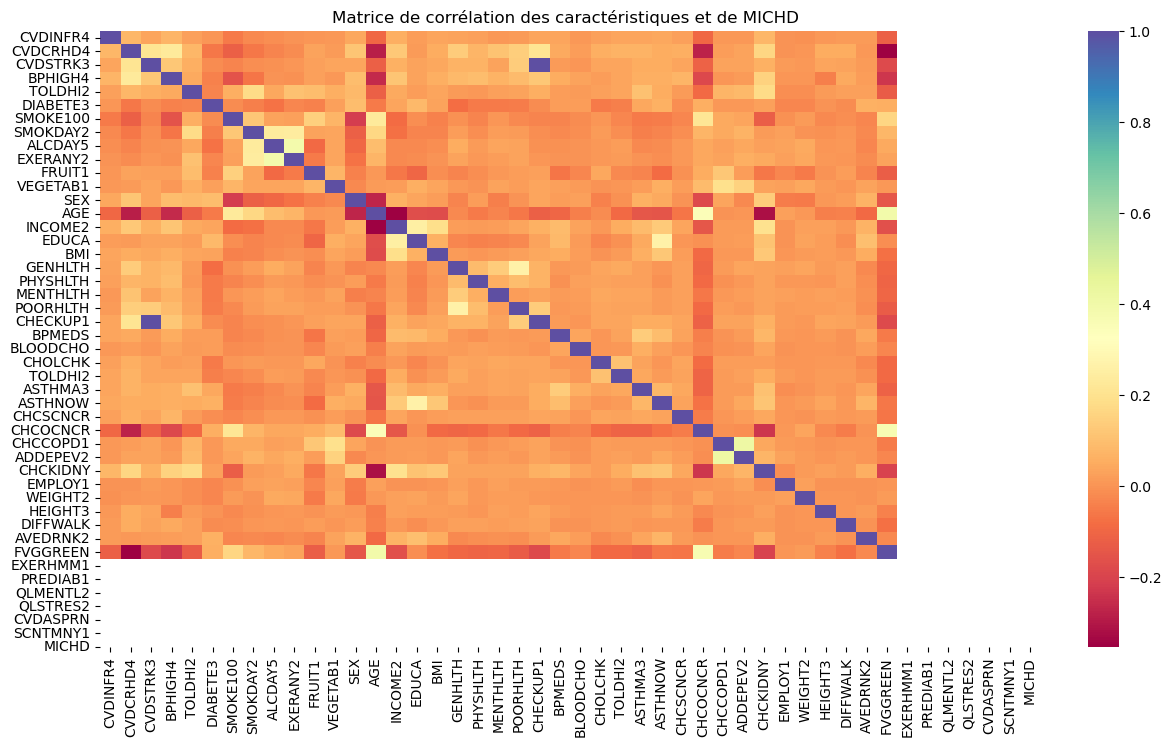

[-0.11944212 -0.35278001 -0.17960308 -0.23427158 -0.12967061  0.05411432
  0.16079014  0.07789966  0.0453694   0.03166851 -0.12299451  0.00871084
 -0.14482142  0.39234175 -0.16486732 -0.00999047 -0.07548418 -0.09666206
 -0.10606385 -0.10287387 -0.12994322 -0.17960308 -0.05372222 -0.02776219
 -0.08980577 -0.09222323 -0.11218666 -0.06205455 -0.06603464  0.36870207
 -0.0497358  -0.02553072 -0.20182751  0.00519905  0.01318647 -0.03999486
 -0.07454754 -0.02370124]


In [11]:
corr_matrix = compute_correlations(x_train_bal, y_train_bal)

plot_correlation_heatmap(x_train_bal, y_train_bal, selected_columns)
print(corr_matrix)

2. Feature Selection techniques :  

using statistical tests or regularized logistic regression (Ridge Regression)

In [12]:
from  implementations import ridge_regression 

lambda_ = 1.0  # Regularization parameter
weights = ridge_regression(y_train_bal, x_train_bal, lambda_)
print(weights)

[-0.02411462 -0.07122791 -0.0254495  -0.04241626 -0.02377598  0.01106822
  0.02653338  0.01190886  0.00657481  0.00446409 -0.03820713  0.00404997
 -0.02126003  0.07945078 -0.02280285  0.00663724 -0.00624339 -0.01522062
 -0.01686979 -0.0202644  -0.02269377 -0.0254495  -0.00655159 -0.00185704
 -0.01947113 -0.01609383 -0.01855838 -0.00523775 -0.01135906  0.07459167
 -0.01038463 -0.0025225  -0.03047178  0.00021642  0.00253996 -0.00476727
 -0.00545691 -0.00107923]


## Model Training ##  

1. Logistic Regression 
2. Ridge Regression

In [38]:
from  implementations import logistic_regression

# Initialize parameters
initial_w = np.zeros((x_train.shape[1], 1))  # assuming x_train has 38 columns after loading
max_iters = 10000
gamma = 1

# Convert y_train and y_test labels to binary (1, 0) for logistic regression
y_train_bin = np.where(y_train_bal == -1, 0, 1)

# Train Logistic Regression
w, loss = logistic_regression(y_train_bin.reshape(-1, 1), x_train_bal, initial_w, max_iters, gamma)


Current iteration=0, loss=0.6931471805599453
Current iteration=100, loss=0.5491802780029538
Current iteration=200, loss=0.5491112058727282
Current iteration=300, loss=0.54909879908475
